In [2]:
import os 
from glob import glob

import torch
from monai.transforms import (
    Compose,
    LoadImaged,
    ToTensord,
    AddChanneld,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    RandAffined,
    RandRotated,
    RandGaussianNoised
)
from monai.data import (
    Dataset,
    DataLoader,
    CacheDataset
)
from monai.utils import first

import matplotlib.pyplot as plt

import numpy as np

import nibabel as nib

In [41]:
number_of_slices = 37

In [42]:
data_dir = 'D:/AI_Imaging/Cancer_Recognision/Liver1/splitted_nifti_final_files'

In [43]:
                                            #monai does not raise error if You would use (.nii.gz) files
                                            #so pay attention to that
train_x_data = sorted(glob(os.path.join(data_dir, 'train_img', '*.nii')))
train_y_data = sorted(glob(os.path.join(data_dir, 'train_labels', '*.nii')))

test_x_data = sorted(glob(os.path.join(data_dir, 'test_img', '*.nii')))
test_y_data = sorted(glob(os.path.join(data_dir, 'test_labels', '*.nii')))

train_data = [{"image":image_name, "label":label_name} for image_name, label_name in zip(train_x_data, train_y_data)]
test_data = [{"image":image_name, "label":label_name} for image_name, label_name in zip(test_x_data, test_y_data)]

In [44]:
# load images
# transforms
#   in case of train data add augmentation
# conversion into torch tensors

orig_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),

        # its for batch sise
        AddChanneld(keys=['image', 'label']),

        ToTensord(keys=['image', 'label'])
    ]
)

                #compose function allows to make transforms in convenient way
train_transforms = Compose(
        # d at the end of those funcitons stands for dictionaries
    [
        LoadImaged(keys=['image', 'label']),

        #we need another channel to represent both foreground and background (tumor) mask
        AddChanneld(keys=['image', 'label']),
        
        #dimension generalization to awoid problems with different data in datasets
        Spacingd(keys=['image', 'label'], pixdim = (1.5, 1.5, 1.0)),
        
        #a param in this function is to get better contrast, b normalizes pixels of image from 0 to 1
        ScaleIntensityRanged(keys='image', a_min = -200, a_max = 200, b_min = 0.0, b_max = 1.0, clip=True),
        #program itk-snap may help in setting this a param
        
        #in affine transformation lines map to lines, parallel lines remain parallel 
        RandAffined(keys = ['image', 'label'], prob = 1, translate_range = 10),
        #                                   prob 1 means all patients, translate_range defines the range to randomly select voxel to conversion image to image

        #
        RandRotated(keys = ['image', 'label'], prob = 1, range_x = 10.0),

        #adds noise, help to gain generalization 
        RandGaussianNoised(keys = 'image', prob = 0.5),

        #remove or adjust the outside edges of an image
        CropForegroundd(keys=['image', 'label'], source_key = 'image'),
        
        #After using crop we will probably get different sizes of images which may cause errors
        Resized(keys=['image', 'label'], spatial_size = [128, 128, number_of_slices]),

        ToTensord(keys=['image', 'label'])
    ]
)

                #compose function allows to make transforms in convenient way
test_transforms = Compose(
        # d at the end of those funcitons stands for dictionaries
    [
        LoadImaged(keys=['image', 'label']),

        #we need another channel to represent both foreground and background (tumor) mask
        AddChanneld(keys=['image', 'label']),
        
        #dimension generalization to awoid problems with different data in datasets
        Spacingd(keys=['image', 'label'], pixdim = (1.5, 1.5, 1.0)),
        
        #a param in this function is to get better contrast, b normalizes pixels of image from 0 to 1
        ScaleIntensityRanged(keys='image', a_min = -200, a_max = 200, b_min = 0.0, b_max = 1.0, clip=True),
        #program itk-snap may help in setting this a param
        
        #remove or adjust the outside edges of an image
        CropForegroundd(keys=['image', 'label'], source_key = 'image'),
        
        #After using crop we will probably get different sizes of images which may cause errors
        Resized(keys=['image', 'label'], spatial_size = [128, 128, number_of_slices]),

        ToTensord(keys=['image', 'label'])
    ]
)


In [45]:
orig_train_data_transformed = Dataset(train_data, orig_transforms)
orig_train_data_loader = DataLoader(orig_train_data_transformed, batch_size = 1)

train_data_transformed = Dataset(train_data, train_transforms)
train_data_loader = DataLoader(train_data_transformed, batch_size = 1)

test_data_transformed = Dataset(train_data, test_transforms)
test_data_loader = DataLoader(train_data_transformed, batch_size = 1)

In [46]:
orig_f_patient = first(orig_train_data_loader)
train_f_patient = first(train_data_loader)
test_f_patient = first(test_data_loader)

In [47]:
orig_f_patient['image'].shape

torch.Size([1, 1, 512, 512, 37])

In [48]:
train_f_patient['image'].shape

torch.Size([1, 1, 128, 128, 37])

In [49]:
test_f_patient['image'].shape

torch.Size([1, 1, 128, 128, 37])

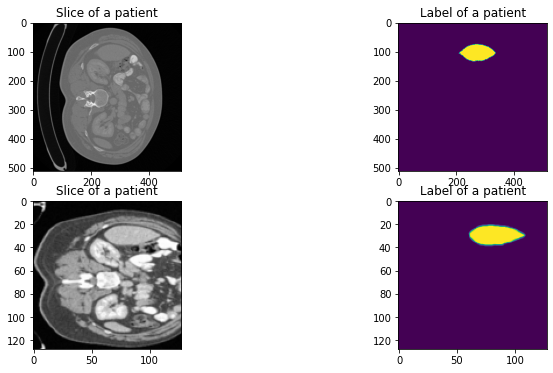

In [50]:
plt.figure('test', (12, 6))

plt.subplot(2, 2, 1)
plt.title('Slice of a patient')
plt.imshow(orig_f_patient['image'][0, 0, : ,: ,30], cmap= "gray")

plt.subplot(2, 2, 2)
plt.title('Label of a patient')
plt.imshow(orig_f_patient['label'][0, 0, : ,: ,30])

plt.subplot(2, 2, 3)
plt.title('Slice of a patient')
plt.imshow(train_f_patient['image'][0, 0, : ,: ,30], cmap= "gray")

plt.subplot(2, 2, 4)
plt.title('Label of a patient')
plt.imshow(train_f_patient['label'][0, 0, : ,: ,30])
plt.show()

In [51]:
def save_nifti(in_image, in_label, out, index = 0):
    # Convert the torch tensors into numpy array
    volume = np.array(in_image.detach().cpu()[0, :, :, :], dtype=np.float32)
    lab = np.array(in_label.detach().cpu()[0, :, :, :], dtype=np.float32)
    
    # Convert the numpy array into nifti file
    volume = nib.Nifti1Image(volume, np.eye(4))
    lab = nib.Nifti1Image(lab, np.eye(4))
    
    # Create the path to save the images and labels
    path_out_images = os.path.join(out, 'img')
    path_out_labels = os.path.join(out, 'labels')
    
    # Make directory if not existing
    if not os.path.exists(path_out_images):
        os.mkdir(path_out_images)
    if not os.path.exists(path_out_labels):
        os.mkdir(path_out_labels)
    
    path_data = os.path.join(out, 'img')
    path_label = os.path.join(out, 'labels')
    nib.save(volume, os.path.join(path_data, f'patient_generated_{index}.nii'))
    nib.save(lab, os.path.join(path_label, f'patient_generated_{index}.nii'))

    print(f'patient_generated_{index} is saved', end='\r')

In [52]:
output_path = 'D:/AI_Imaging/Cancer_Recognision/Liver1/generated_data'
number_runs = 1
for i in range(number_runs):
    name_folder = 'generated_data_' + str(i)
    os.mkdir(os.path.join(output_path, name_folder))
    output = os.path.join(output_path, name_folder)
    check_ds = Dataset(train_data, train_transforms)
    check_loader = DataLoader(check_ds, batch_size=1)
    check_data = first(check_loader)
    for index, patient in enumerate(check_loader):
        save_nifti(patient['image'], patient['label'], output, index)
    print(f'step {i} done')


step 0 doneerated_29 is saved


In [54]:
train_ds = CacheDataset(data=train_data, transform=train_transforms,cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=1)

test_ds = CacheDataset(data=test_data, transform=test_transforms, cache_rate=1.0)
test_loader = DataLoader(test_ds, batch_size=1)


# train_ds = Dataset(data=train_files, transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=1)

# test_ds = Dataset(data=test_files, transform=test_transforms)
# test_loader = DataLoader(test_ds, batch_size=1)

Loading dataset: 100%|██████████| 12/12 [00:23<00:00,  1.97s/it]
